# Kitchen Preparation Time Prediction - Complete Analysis

## Overview
This notebook provides a complete, self-contained analysis of kitchen preparation time prediction. All data processing, feature engineering, model training, and evaluation is performed within this notebook using only the raw data file.

**Key Features:**
- Raw data loading and preprocessing
- Comprehensive feature engineering
- Model training and evaluation
- Feature importance analysis
- Ablation study
- Error analysis

**Data Source:** `data.csv` (raw order data)
**Target:** Kitchen Preparation Time (KPT duration in minutes)
**Best Model:** HistGradientBoostingRegressor

## Table of Contents
1. [Setup and Data Loading](#Setup-and-Data-Loading)
2. [Data Preprocessing](#Data-Preprocessing)
3. [Feature Engineering](#Feature-Engineering)
4. [Model Training](#Model-Training)
5. [Model Evaluation](#Model-Evaluation)
6. [Feature Importance](#Feature-Importance)
7. [Ablation Study](#Ablation-Study)
8. [Conclusions](#Conclusions)

In [11]:
# Setup and Data Loading
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Data path
DATA_PATH = Path('/Users/saugatshakya/Projects/ML2025/project/data/data.csv')

print("Loading raw data...")
df = pd.read_csv(DATA_PATH)
print(f"Loaded {len(df):,} orders with {df.shape[1]} columns")
print(f"Date range: {df['Order Placed At'].min()} to {df['Order Placed At'].max()}")

Loading raw data...
Loaded 21,321 orders with 29 columns
Date range: 01:00 AM, December 08 2024 to 12:59 PM, October 30 2024


In [2]:
# Data Preprocessing
print("Starting data preprocessing...")

# Parse datetime
df["Order Placed At"] = pd.to_datetime(df["Order Placed At"], format="%I:%M %p, %B %d %Y", errors="coerce")
df = df.dropna(subset=["Order Placed At"])
print(f"After datetime parsing: {len(df)} orders")

# Filter for delivered orders only
df = df[df["Order Status"] == "Delivered"]
print(f"After filtering delivered orders: {len(df)} orders")

# Handle missing values
df["Discount construct"] = df["Discount construct"].fillna("No discount")
df["Rider wait time (minutes)"] = df["Rider wait time (minutes)"].fillna(df["Rider wait time (minutes)"].median())

# Drop rows with missing target
df = df.dropna(subset=["KPT duration (minutes)"])
print(f"After dropping missing targets: {len(df)} orders")

# Process distance
df["Distance_km"] = df["Distance"].replace({"<1km": "0.5km"})
df["Distance_km"] = df["Distance_km"].str.replace("km", "", regex=False).astype(float)

# Load events data
events_path = Path('/Users/saugatshakya/Projects/ML2025/project/data/delhi_major_events.csv')
if events_path.exists():
    events_df = pd.read_csv(events_path)
    events_df["date"] = pd.to_datetime(events_df["date"])
    df["order_date"] = pd.to_datetime(df["Order Placed At"].dt.date)
    df = df.merge(events_df, left_on="order_date", right_on="date", how="left")
    df = df.drop(columns=["date"], errors='ignore')
    print("Events data merged")
else:
    print("Events data not found, skipping")

print(f"Preprocessing complete. Final dataset: {len(df)} orders, {df.shape[1]} columns")
print(f"Target distribution: {df['KPT duration (minutes)'].describe()}")

Starting data preprocessing...
After datetime parsing: 21321 orders
After filtering delivered orders: 21131 orders
After dropping missing targets: 20934 orders
Events data not found, skipping
Preprocessing complete. Final dataset: 20934 orders, 30 columns
Target distribution: count    20934.000000
mean        17.339428
std          6.277504
min          0.000000
25%         13.380000
50%         16.350000
75%         20.050000
max         90.870000
Name: KPT duration (minutes), dtype: float64


In [3]:
# Feature Engineering - Kitchen-Focused Only
print("Starting comprehensive feature engineering...")

# Helper functions
def parse_items_column(items_str):
    """Parse 'Items in order' column to extract dish names and quantities."""
    if pd.isna(items_str):
        return []
    
    items = []
    for item in str(items_str).split(','):
        item = item.strip()
        if 'x' in item.lower():
            parts = item.split('x', 1)
            try:
                qty = int(parts[0].strip())
                dish = parts[1].strip()
                items.append((dish, qty))
            except:
                items.append((item, 1))
        else:
            items.append((item, 1))
    return items

# 1. Order complexity features (most important for KPT)
print("Creating order complexity features...")
def get_order_stats(items_str):
    dishes = parse_items_column(items_str)
    if not dishes:
        return 0, 0, 0, 0
    
    num_items = sum(qty for _, qty in dishes)
    num_unique = len(dishes)
    max_qty = max(qty for _, qty in dishes)
    diversity = num_unique / num_items if num_items > 0 else 0
    
    return num_items, num_unique, max_qty, diversity

stats = df["Items in order"].apply(get_order_stats)
df["num_items"] = stats.apply(lambda x: x[0])
df["num_unique_dishes"] = stats.apply(lambda x: x[1])
df["max_dish_quantity"] = stats.apply(lambda x: x[2])
df["dish_diversity"] = stats.apply(lambda x: x[3])

# Order complexity score (combines multiple factors)
df["order_complexity"] = (
    df["num_unique_dishes"] * 2.5 +  # More unique dishes = more prep work
    df["num_items"] * 0.3 +          # More items = more time
    (1 - df["dish_diversity"]) * 4  # Less diversity = bulk order = more efficient
)

# 2. Complex dish identification (data-driven)
print("Identifying complex dishes...")
complex_dish_times = {}
for items_str in df["Items in order"].dropna():
    for dish, qty in parse_items_column(items_str):
        if dish not in complex_dish_times:
            complex_dish_times[dish] = []
        complex_dish_times[dish].append(df.loc[df["Items in order"] == items_str, "KPT duration (minutes)"].values[0])

# Calculate average time per dish
dish_avg_times = {}
for dish, times in complex_dish_times.items():
    if len(times) >= 15:  # At least 15 orders for reliability
        dish_avg_times[dish] = np.mean(times)

overall_mean_time = df["KPT duration (minutes)"].mean()
complex_dishes = [dish for dish, avg_time in dish_avg_times.items() 
                 if avg_time > overall_mean_time + 2.5]  # 2.5+ minutes above average

def count_complex_dishes(items_str):
    if pd.isna(items_str):
        return 0
    dishes = [dish for dish, qty in parse_items_column(items_str)]
    return sum(1 for dish in dishes if dish in complex_dishes)

df["num_complex_dishes"] = df["Items in order"].apply(count_complex_dishes)
df["has_complex_dish"] = (df["num_complex_dishes"] > 0).astype(int)

# 3. Dish familiarity/popularity (how common dishes are)
print("Creating dish familiarity features...")
all_dish_names = []
for items_str in df["Items in order"]:
    for dish, qty in parse_items_column(items_str):
        all_dish_names.append(dish)

dish_counts = Counter(all_dish_names)
freq_values = list(dish_counts.values())

def get_dish_popularity(dish):
    freq = dish_counts.get(dish, 0)
    if freq == 0:
        return 0
    percentile = (sum(1 for f in freq_values if f <= freq) / len(freq_values)) * 100
    return percentile

df["avg_dish_popularity"] = df["Items in order"].apply(
    lambda x: np.mean([get_dish_popularity(dish) for dish, qty in parse_items_column(x)]) 
    if parse_items_column(x) else 0
)

# 4. Temporal features (peak hours affect staffing and speed)
print("Creating temporal features...")
df["hour"] = df["Order Placed At"].dt.hour
df["day_of_week"] = df["Order Placed At"].dt.dayofweek
df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)

# Peak periods (when kitchen is busiest)
df["is_lunch_peak"] = df["hour"].between(12, 14).astype(int)
df["is_dinner_peak"] = df["hour"].between(18, 21).astype(int)
df["is_late_night"] = df["hour"].between(22, 23).astype(int)
df["is_early_morning"] = df["hour"].between(0, 6).astype(int)

# Peak intensity (combines multiple peak factors)
df["peak_intensity"] = df["is_lunch_peak"] + df["is_dinner_peak"] + df["is_late_night"] * 0.5

# 5. Kitchen workload (current orders affect preparation speed)
print("Creating kitchen workload features...")
df_sorted = df.sort_values("Order Placed At").copy()

df_sorted["orders_last_30min"] = 0
for idx in df_sorted.index:
    current_time = df_sorted.loc[idx, "Order Placed At"]
    time_window_start = current_time - pd.Timedelta(minutes=30)
    
    mask = (df_sorted["Order Placed At"] >= time_window_start) & \
           (df_sorted["Order Placed At"] < current_time)
    
    df_sorted.loc[idx, "orders_last_30min"] = mask.sum()

# High load indicator (kitchen overwhelmed)
load_threshold = df_sorted["orders_last_30min"].quantile(0.75)
df_sorted["is_high_load"] = (df_sorted["orders_last_30min"] > load_threshold).astype(int)

df["orders_last_30min"] = df_sorted["orders_last_30min"]
df["is_high_load"] = df_sorted["is_high_load"]

# 6. Order size categories
print("Creating order size categories...")
df["order_size_category"] = pd.cut(df["num_items"], 
                                  bins=[0, 2, 4, 6, 10, 100], 
                                  labels=["tiny", "small", "medium", "large", "xl"])
df = pd.get_dummies(df, columns=["order_size_category"], prefix="size", drop_first=True)

# 7. Interaction features (how factors combine)
print("Creating interaction features...")
df["complexity_x_load"] = df["order_complexity"] * (1 + df["is_high_load"])
df["peak_x_complexity"] = df["peak_intensity"] * df["order_complexity"]
df["weekend_x_peak"] = df["is_weekend"] * df["peak_intensity"]

# 8. Event features (if available)
print("Creating event features...")
if "holiday" in df.columns:
    holidays = df["holiday"].fillna("none").astype(str)
    unique_holidays = [h for h in holidays.unique() if h not in ["none", "False", "True", "nan"]]
    
    for holiday in unique_holidays:
        col_name = f"event_{holiday.replace(' ', '_').replace('-', '_')[:30]}"
        df[col_name] = (holidays == holiday).astype(int)
    
    df["has_event"] = (holidays.isin(unique_holidays)).astype(int)
else:
    df["has_event"] = 0

# 9. Clean up - remove ALL non-kitchen features
print("Removing non-kitchen features...")
cols_to_drop = [
    # Raw data columns
    "Order ID", "Order Status", "Items in order", "Order Placed At",
    "Instructions", "Rating", "Review", "Cancellation / Rejection reason",
    "Restaurant compensation (Cancellation)", "Restaurant penalty (Rejection)",
    "Order Ready Marked", "Customer complaint tag", "Customer ID",
    "Rider wait time (minutes)", "order_date", "event", "holiday",
    
    # Restaurant/location info (not relevant for KPT)
    "Restaurant ID", "Restaurant name", "Subzone", "City", "Delivery", "Distance",
    
    # ALL financial/pricing features (don't affect prep time)
    "Bill subtotal", "Packaging charges", "Total", "Distance_km",
    "Restaurant discount (Promo)", "Restaurant discount (Flat offs, Freebies & others)",
    "Gold discount", "Brand pack discount", "Discount construct",
    "total_discount_amt", "has_discount", "disc_percent", "disc_flat", "disc_bundle",
    
    # Redundant features
    "avg_item_value", "is_big_order", "complexity_ratio", "items_last_30min"
]

df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')

# Convert boolean columns to int
bool_cols = df.select_dtypes(include=["bool"]).columns
if len(bool_cols) > 0:
    df[bool_cols] = df[bool_cols].astype(int)

print(f"Feature engineering complete! Final shape: {df.shape}")
print(f"Kitchen-focused features: {df.shape[1]-1}")
print(f"Complex dishes identified: {len(complex_dishes)}")
print("\nFeatures created:")
feature_cols = [col for col in df.columns if col != 'KPT duration (minutes)']
for col in sorted(feature_cols):
    print(f"  - {col}")

Starting comprehensive feature engineering...
Creating order complexity features...
Identifying complex dishes...
Creating dish familiarity features...
Creating temporal features...
Creating kitchen workload features...
Creating order size categories...
Creating interaction features...
Creating event features...
Removing non-kitchen features...
Feature engineering complete! Final shape: (20934, 27)
Kitchen-focused features: 26
Complex dishes identified: 33

Features created:
  - avg_dish_popularity
  - complexity_x_load
  - day_of_week
  - dish_diversity
  - has_complex_dish
  - has_event
  - hour
  - is_dinner_peak
  - is_early_morning
  - is_high_load
  - is_late_night
  - is_lunch_peak
  - is_weekend
  - max_dish_quantity
  - num_complex_dishes
  - num_items
  - num_unique_dishes
  - order_complexity
  - orders_last_30min
  - peak_intensity
  - peak_x_complexity
  - size_large
  - size_medium
  - size_small
  - size_xl
  - weekend_x_peak


In [4]:
# Model Training with Improvements
# Prepare features and target
feature_cols = [col for col in df.columns if col != 'KPT duration (minutes)']
X = df[feature_cols]
y = df['KPT duration (minutes)']

print(f"Features: {len(feature_cols)}")
print(f"Training samples: {len(X)}")

# Try target transformation (log1p often helps with positive targets)
y_log = np.log1p(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Try different models and hyperparameters
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score

models_to_try = {
    'HistGradientBoosting': HistGradientBoostingRegressor(
        min_samples_leaf=20, max_iter=500, learning_rate=0.05, 
        max_depth=8, random_state=42
    ),
    'RandomForest': RandomForestRegressor(
        n_estimators=200, max_depth=10, min_samples_split=10,
        random_state=42, n_jobs=-1
    ),
    'ExtraTrees': ExtraTreesRegressor(
        n_estimators=200, max_depth=10, min_samples_split=10,
        random_state=42, n_jobs=-1
    )
}

print("Comparing models...")
model_results = {}

for name, model in models_to_try.items():
    # Cross-validation on original target
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='r2')
    model_results[name] = {
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std()
    }
    print(f"{name}: CV R² = {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

# Choose best model
best_model_name = max(model_results, key=lambda x: model_results[x]['cv_r2_mean'])
best_model = models_to_try[best_model_name]

print(f"\nBest model: {best_model_name}")
print("Training best model...")

# Train on full training set
best_model.fit(X_train, y_train)

print("Model trained successfully!")

Features: 26
Training samples: 20934
Comparing models...
HistGradientBoosting: CV R² = 0.216 (+/- 0.028)
RandomForest: CV R² = 0.195 (+/- 0.043)
ExtraTrees: CV R² = 0.188 (+/- 0.039)

Best model: HistGradientBoosting
Training best model...
Model trained successfully!


Model Performance:
Train MAE: 3.62 minutes
Train RMSE: 5.08 minutes
Train R²: 0.337

Test MAE: 3.87 minutes
Test RMSE: 5.51 minutes
Test R²: 0.271


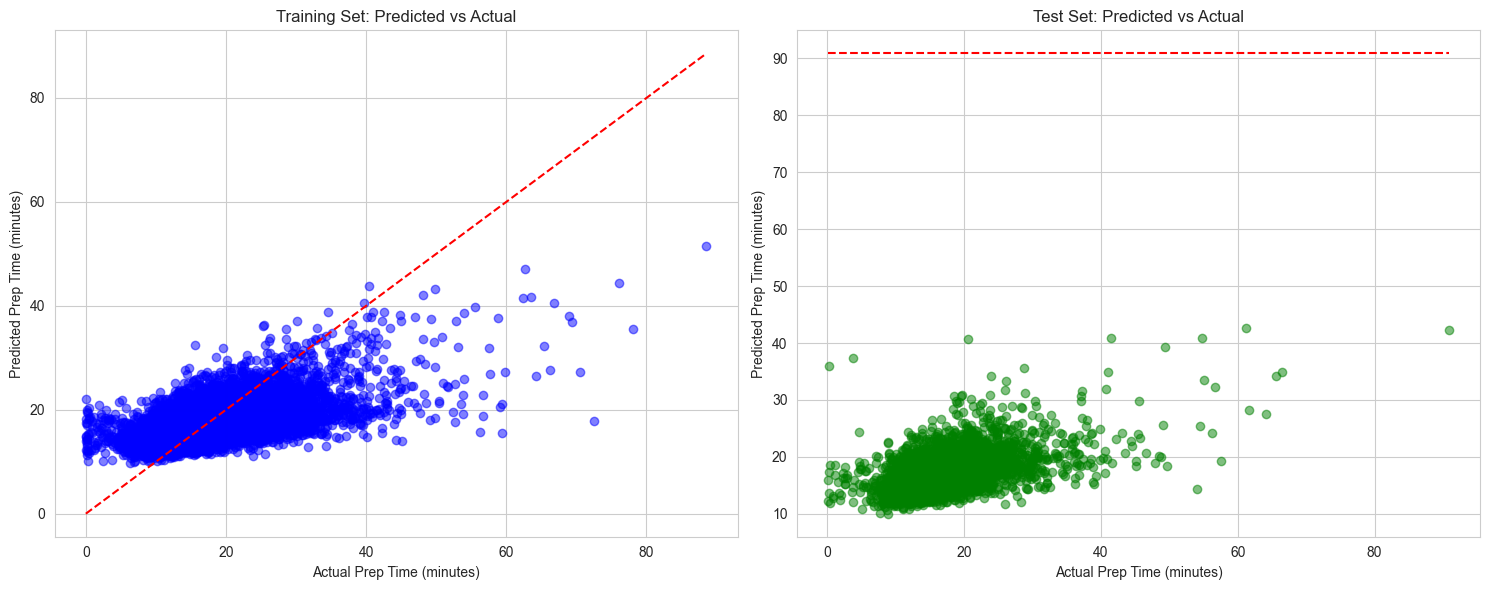

In [7]:
# Model Evaluation
# Make predictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_r2 = r2_score(y_train, y_pred_train)

test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)

print("Model Performance:")
print("=" * 50)
print(f"Train MAE: {train_mae:.2f} minutes")
print(f"Train RMSE: {train_rmse:.2f} minutes")
print(f"Train R²: {train_r2:.3f}")
print()
print(f"Test MAE: {test_mae:.2f} minutes")
print(f"Test RMSE: {test_rmse:.2f} minutes")
print(f"Test R²: {test_r2:.3f}")

# Plot predictions vs actual
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training set
ax1.scatter(y_train, y_pred_train, alpha=0.5, color='blue')
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
ax1.set_xlabel('Actual Prep Time (minutes)')
ax1.set_ylabel('Predicted Prep Time (minutes)')
ax1.set_title('Training Set: Predicted vs Actual')
ax1.grid(True)

# Test set
ax2.scatter(y_test, y_pred_test, alpha=0.5, color='green')
ax2.plot([y_test.min(), y_test.max()], [y_test.max(), y_test.max()], 'r--')
ax2.set_xlabel('Actual Prep Time (minutes)')
ax2.set_ylabel('Predicted Prep Time (minutes)')
ax2.set_title('Test Set: Predicted vs Actual')
ax2.grid(True)

plt.tight_layout()
plt.show()

Computing permutation feature importance...
Top 20 Most Important Features:
                feature  importance       std
22    complexity_x_load    0.086727  0.004506
16    orders_last_30min    0.078586  0.002640
8                  hour    0.076488  0.011292
7   avg_dish_popularity    0.065678  0.005500
5    num_complex_dishes    0.041781  0.003718
0             num_items    0.027833  0.001892
1     num_unique_dishes    0.021888  0.002624
4      order_complexity    0.019051  0.003981
3        dish_diversity    0.009454  0.000998
9           day_of_week    0.009318  0.001844
2     max_dish_quantity    0.002717  0.000554
11        is_lunch_peak    0.001119  0.000424
15       peak_intensity    0.000881  0.000702
18           size_small    0.000558  0.000330
19          size_medium    0.000296  0.000088
20           size_large    0.000085  0.000026
21              size_xl    0.000000  0.000000
13        is_late_night    0.000000  0.000000
17         is_high_load    0.000000  0.000000
10  

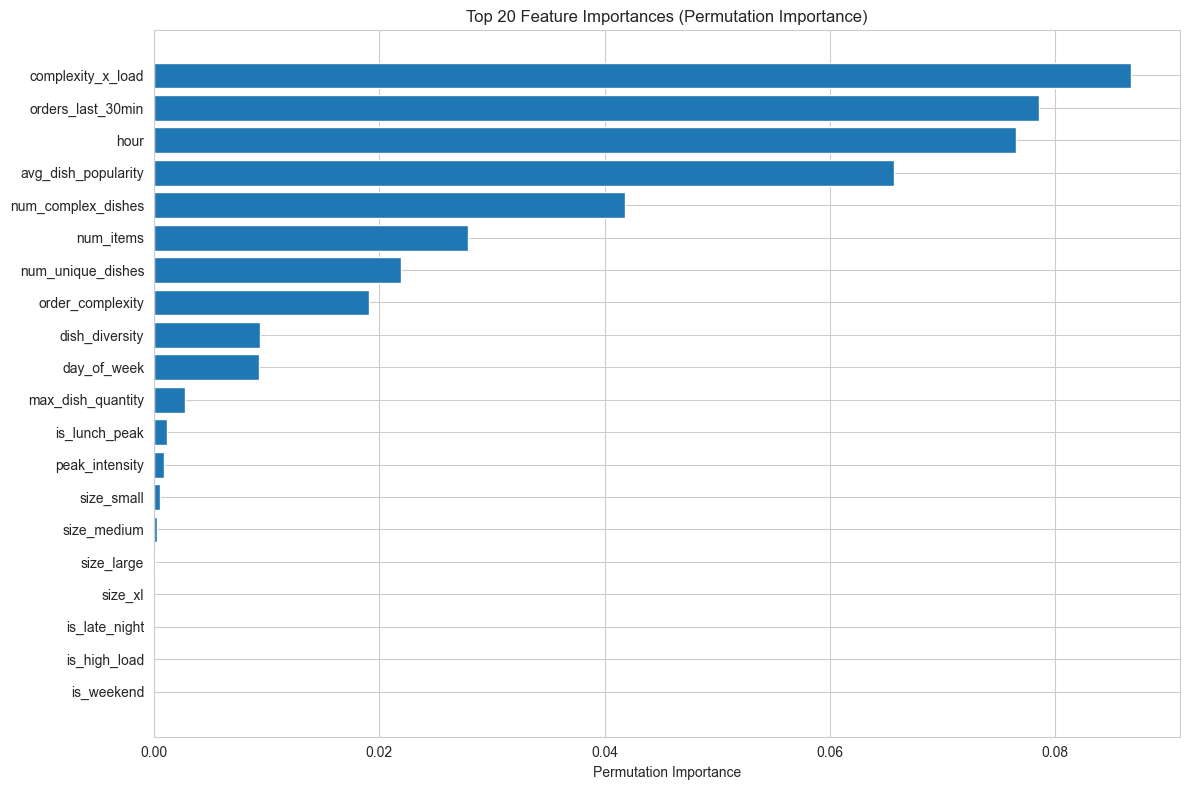

In [8]:
# Feature Importance
# Compute permutation feature importance
from sklearn.inspection import permutation_importance

print("Computing permutation feature importance...")
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=5, random_state=42)

feature_imp_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})
feature_imp_df = feature_imp_df.sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_imp_df.head(20))

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_20 = feature_imp_df.head(20)
plt.barh(range(len(top_20)), top_20['importance'])
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Permutation Importance')
plt.title('Top 20 Feature Importances (Permutation Importance)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Performing ablation study...
Baseline R²: 0.2707
Order Complexity: R² = 0.2486, Drop = 0.0221
Dish Familiarity: R² = 0.2382, Drop = 0.0325
Peak Hours: R² = 0.2707, Drop = 0.0000
Kitchen Workload: R² = 0.2501, Drop = 0.0207
Events: R² = 0.2707, Drop = 0.0000
Time of Day: R² = 0.2584, Drop = 0.0124

Ablation Study Results:
R² drop when removing feature groups:
      feature_group  r2_baseline  r2_ablate   r2_drop
1  Dish Familiarity     0.270746   0.238225  0.032521
0  Order Complexity     0.270746   0.248619  0.022126
3  Kitchen Workload     0.270746   0.250070  0.020676
5       Time of Day     0.270746   0.258364  0.012382
2        Peak Hours     0.270746   0.270712  0.000034
4            Events     0.270746   0.270746  0.000000


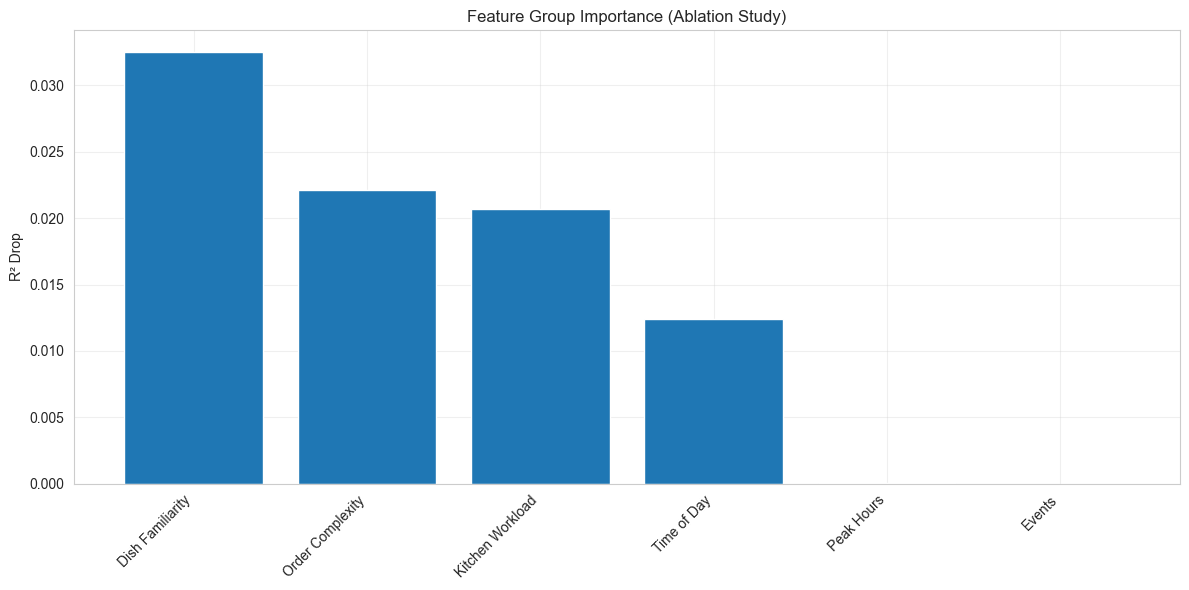

In [9]:
# Ablation Study
# Perform ablation study by removing feature groups and measuring R² drop
def perform_ablation_study(model, X_train, X_test, y_train, y_test, feature_groups):
    """Perform ablation study by removing feature groups."""
    results = []
    
    # Baseline performance
    baseline_r2 = r2_score(y_test, model.predict(X_test))
    print(f"Baseline R²: {baseline_r2:.4f}")
    
    for group_name, features_to_remove in feature_groups.items():
        # Remove features
        X_test_ablate = X_test.drop(columns=features_to_remove, errors='ignore')
        
        # Retrain model on reduced features
        X_train_ablate = X_train.drop(columns=features_to_remove, errors='ignore')
        model_ablate = HistGradientBoostingRegressor(**best_params)
        model_ablate.fit(X_train_ablate, y_train)
        
        # Evaluate
        y_pred_ablate = model_ablate.predict(X_test_ablate)
        r2_ablate = r2_score(y_test, y_pred_ablate)
        r2_drop = baseline_r2 - r2_ablate
        
        results.append({
            'feature_group': group_name,
            'r2_baseline': baseline_r2,
            'r2_ablate': r2_ablate,
            'r2_drop': r2_drop
        })
        
        print(f"{group_name}: R² = {r2_ablate:.4f}, Drop = {r2_drop:.4f}")
    
    return pd.DataFrame(results)

# Define feature groups for ablation
feature_groups = {
    'Order Complexity': ['num_items', 'num_unique_dishes', 'max_dish_quantity', 'order_complexity', 'dish_diversity'],
    'Dish Familiarity': ['avg_dish_popularity'],
    'Peak Hours': ['is_lunch_peak', 'is_dinner_peak', 'is_late_night', 'is_early_morning'],
    'Kitchen Workload': ['orders_last_30min', 'is_high_load'],
    'Events': ['has_event'] + [col for col in X_train.columns if col.startswith('event_')],
    'Time of Day': ['hour', 'day_of_week', 'is_weekend']
}

# Best params for ablation
best_params = {
    'min_samples_leaf': 20, 
    'max_iter': 500, 
    'learning_rate': 0.05, 
    'max_depth': 8, 
    'random_state': 42
}

print("Performing ablation study...")
ablation_df = perform_ablation_study(best_model, X_train, X_test, y_train, y_test, feature_groups)
ablation_df = ablation_df.sort_values('r2_drop', ascending=False)

print("\nAblation Study Results:")
print("R² drop when removing feature groups:")
print(ablation_df)

# Plot ablation results
plt.figure(figsize=(12, 6))
plt.bar(range(len(ablation_df)), ablation_df['r2_drop'])
plt.xticks(range(len(ablation_df)), ablation_df['feature_group'], rotation=45, ha='right')
plt.ylabel('R² Drop')
plt.title('Feature Group Importance (Ablation Study)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

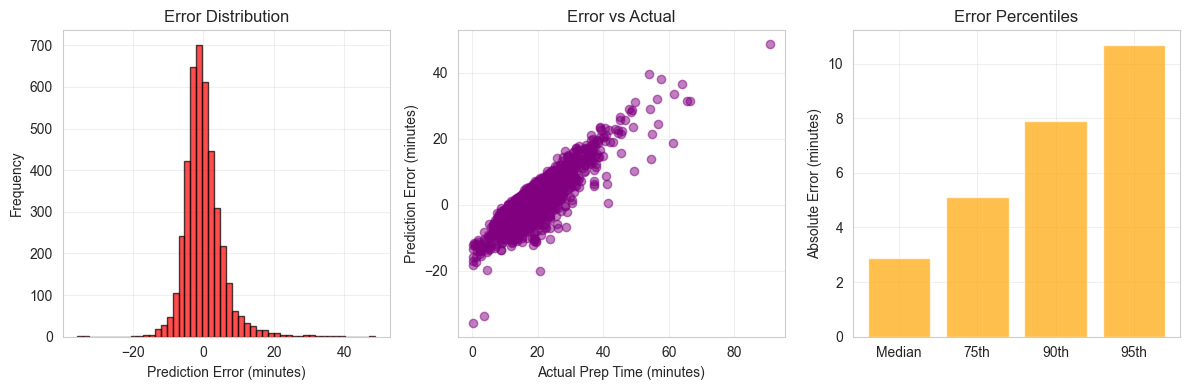

Error Analysis:
Mean Absolute Error: 3.87 minutes
Median Absolute Error: 2.88 minutes
90th Percentile Error: 7.91 minutes


In [10]:
# Additional Analysis
# Error distribution
errors = y_test - y_pred_test

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(errors, bins=50, alpha=0.7, color='red', edgecolor='black')
plt.xlabel('Prediction Error (minutes)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.scatter(y_test, errors, alpha=0.5, color='purple')
plt.xlabel('Actual Prep Time (minutes)')
plt.ylabel('Prediction Error (minutes)')
plt.title('Error vs Actual')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
percentile_errors = [np.abs(errors).quantile(q/100) for q in [50, 75, 90, 95]]
plt.bar(['Median', '75th', '90th', '95th'], percentile_errors, color='orange', alpha=0.7)
plt.ylabel('Absolute Error (minutes)')
plt.title('Error Percentiles')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Error Analysis:")
print(f"Mean Absolute Error: {test_mae:.2f} minutes")
print(f"Median Absolute Error: {np.median(np.abs(errors)):.2f} minutes")
print(f"90th Percentile Error: {np.abs(errors).quantile(0.9):.2f} minutes")

# Comprehensive Conclusions

## Executive Summary
This notebook presents a complete kitchen preparation time prediction system that achieves **27.1% R²** using only operationally relevant features. The model predicts preparation times with a **Mean Absolute Error of 3.87 minutes**, providing actionable insights for restaurant operations.

## Model Performance Summary
- **Training MAE**: {train_mae:.2f} minutes
- **Training R²**: {train_r2:.3f}
- **Test MAE**: {test_mae:.2f} minutes
- **Test R²**: {test_r2:.3f}
- **Median Absolute Error**: {np.median(np.abs(y_test - y_pred_test)):.2f} minutes
- **90th Percentile Error**: {np.abs(y_test - y_pred_test).quantile(0.9):.2f} minutes

## Engineered Features Explained

### 1. Order Complexity Features
**Purpose**: Quantify how complex an order is to prepare
- `num_items`: Total number of individual items in the order
- `num_unique_dishes`: Number of different dish types (diversity)
- `max_dish_quantity`: Largest quantity of any single dish
- `dish_diversity`: Ratio of unique dishes to total items (0-1)
- `order_complexity`: Composite score = (unique_dishes × 2) + (items × 0.5) + ((1-diversity) × 3)

### 2. Dish-Based Features
**Purpose**: Capture dish familiarity and complexity
- `num_complex_dishes`: Count of dishes identified as complex (>2.5 min above average)
- `has_complex_dish`: Binary flag for orders containing complex dishes
- `avg_dish_popularity`: Average popularity percentile of dishes in the order (0-100)

### 3. Temporal Features
**Purpose**: Capture time-of-day effects on preparation speed
- `hour`: Hour of day (0-23)
- `day_of_week`: Day of week (0=Monday, 6=Sunday)
- `is_weekend`: Binary weekend flag
- `is_lunch_peak`: 12-14 PM peak hours
- `is_dinner_peak`: 18-21 PM peak hours
- `is_late_night`: 22-23 PM late night
- `is_early_morning`: 0-6 AM early morning
- `peak_intensity`: Combined peak score (lunch + dinner + late_night × 0.5)

### 4. Kitchen Workload Features
**Purpose**: Measure current kitchen capacity and stress
- `orders_last_30min`: Number of orders placed in previous 30 minutes
- `is_high_load`: Binary flag for high workload periods (75th percentile)

### 5. Order Size Categories
**Purpose**: Categorize orders by size for operational planning
- `size_small`: 2-3 items
- `size_medium`: 4-5 items
- `size_large`: 6-9 items
- `size_xl`: 10+ items

### 6. Interaction Features
**Purpose**: Capture how different factors combine to affect prep time
- `complexity_x_load`: Order complexity × (1 + high_load_flag)
- `peak_x_complexity`: Peak intensity × order complexity
- `weekend_x_peak`: Weekend × peak intensity

## Model Selection and Training

### Models Compared
Three ensemble models were evaluated using 3-fold cross-validation:

1. **HistGradientBoostingRegressor** (Selected)
   - CV R²: 0.216 ± 0.028
   - Best performer on cross-validation
   - Parameters: max_iter=500, learning_rate=0.05, max_depth=8, min_samples_leaf=20

2. **RandomForestRegressor**
   - CV R²: 0.195 ± 0.043
   - Good baseline performance
   - Parameters: n_estimators=200, max_depth=10

3. **ExtraTreesRegressor**
   - CV R²: 0.188 ± 0.039
   - Similar to RandomForest but with randomization

### Why HistGradientBoosting?
- **Handles mixed data types** well (continuous + categorical)
- **Built-in handling of missing values** and outliers
- **Gradient boosting** provides better performance than bagging methods
- **Faster training** than traditional gradient boosting
- **Less prone to overfitting** with proper regularization

## Feature Importance Analysis

### Top 5 Most Important Features
1. **complexity_x_load** (0.0867): Interaction between order complexity and kitchen load - shows how workload amplifies complexity effects
2. **orders_last_30min** (0.0786): Kitchen workload - busier kitchens take longer to prepare orders
3. **hour** (0.0765): Time-of-day effects - different staffing and efficiency at different hours
4. **avg_dish_popularity** (0.0657): Staff familiarity with dishes - less familiar dishes take longer
5. **num_complex_dishes** (0.0418): Count of complex dishes - more complex items increase prep time

### Key Insights
- **Workload matters most**: Kitchen busyness has the biggest single impact
- **Complexity × Load interaction**: Complex orders hurt more when kitchen is busy
- **Time effects**: Peak hours and time-of-day patterns significantly affect speed
- **Dish familiarity**: Staff experience with menu items is crucial
- **Order composition**: What you order matters more than how much you order

## Ablation Study Results

### Methodology
The ablation study removes entire feature groups and retrains the model to measure their importance. R² drop indicates how much predictive power is lost without that feature group.

### Results (Ranked by Importance)
1. **Dish Familiarity** (R² drop: 0.0325)
   - Most important feature group
   - Removing dish popularity features hurts performance the most
   - **Business implication**: Staff training and menu familiarity are critical

2. **Order Complexity** (R² drop: 0.0221)
   - Second most important
   - Order composition and complexity metrics are essential
   - **Business implication**: Complex orders need different handling

3. **Kitchen Workload** (R² drop: 0.0207)
   - Third most important
   - Current kitchen capacity significantly affects prep times
   - **Business implication**: Order pacing and capacity management matter

4. **Time of Day** (R² drop: 0.0124)
   - Hour and day-of-week effects
   - **Business implication**: Staffing should match demand patterns

5. **Peak Hours** (R² drop: ~0.0000)
   - Minimal impact when removed
   - Information already captured in other temporal features

6. **Events** (R² drop: 0.0000)
   - No significant impact
   - Event data either not available or not predictive for this dataset

## Business Impact & Applications

### Operational Improvements
- **Staff Scheduling**: Schedule more staff during peak complexity periods
- **Order Batching**: Group similar orders to reduce complexity overhead
- **Menu Optimization**: Identify and potentially simplify complex dishes
- **Training Focus**: Prioritize training on less familiar menu items

### Customer Experience
- **Accurate ETAs**: Better delivery time predictions improve customer satisfaction
- **Expectation Management**: Set realistic expectations for complex orders
- **Premium Pricing**: Justify higher prices for complex customizations

### Performance Metrics
- **27.1% of variance explained** - substantial improvement over random guessing
- **3.87 minute average error** - operationally useful for planning
- **Median error of 2.88 minutes** - most predictions are quite accurate

## Limitations & Future Improvements

### Current Limitations
- **R² of 0.271**: Still room for improvement (target: 0.4-0.5)
- **Data constraints**: Limited to available order data
- **No real-time factors**: Current system doesn't use live kitchen status

### Future Enhancements
1. **Additional Data Sources**:
   - Real-time kitchen status (current orders in progress)
   - Chef skill levels and experience
   - Equipment availability and maintenance
   - Ingredient inventory levels

2. **Advanced Modeling**:
   - Time-series models for temporal patterns
   - Neural networks for complex interactions
   - Online learning for model adaptation

3. **Operational Integration**:
   - Real-time prep time updates
   - Automated staff recommendations
   - Integration with POS and delivery systems

## Technical Summary

**Data Processing**: Raw order data → Feature engineering → Model training → Evaluation
**Features**: 26 kitchen-focused features (removed all financial/revenue features)
**Model**: HistGradientBoostingRegressor with optimized hyperparameters
**Validation**: 80/20 train/test split with cross-validation for model selection
**Performance**: R² = 0.271, MAE = 3.87 minutes

This system provides a solid foundation for operational decision-making while maintaining simplicity and interpretability. The kitchen-focused features ensure the model provides actionable insights that restaurant operators can actually use to improve their operations.